科目名から科目タイプを推定するディープラーニングプログラムです。

Googleが提供するTensorFlowとラッパーライブラリのKerasを使用しています。
特徴は科目名をgensimで分散表現を学習した後に、その重みを初期値として設定した Keras の Embedding層を取得します。

参考情報
gensimを使ってKerasのEmbedding層を取得する（http://hironsan.hatenablog.com/entry/keras-gensim-integration）

In [1]:
# import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import word2vec
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, LSTM
import MeCab

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 勘定科目マスターの読み込み
Account_master = pd.ExcelFile('Data/勘定コードマスタ.xlsx')
df_account_master = Account_master.parse('勘定コードマスタ')

In [3]:
df_account_master.head()

,勘定コード,科目名,勘定タイプ,勘定クラス
0,1111000010,現金,資産,C_現預金
1,1111009010,他預貯金-未着資金,資産,C_現預金
2,1111009950,他預貯金-事業領域調整,資産,C_現預金
3,1111009970,他預貯金-会社間取引,資産,C_現預金
4,1111009990,他預貯金-他,資産,C_現預金


In [4]:
# 試算表（新規科目含む）の読み込み
TB_file = pd.ExcelFile('Data/試算表.xlsx')
df_TB_data = TB_file.parse('試算表')

In [5]:
df_TB_data.head()

,勘定コード,科目名,勘定タイプ,勘定クラス
0,1111000010,現金,資産,C_現預金
1,1111009010,他預貯金-未着資金,資産,C_現預金
2,1111009950,他預貯金-事業領域調整,資産,C_現預金
3,1111009970,他預貯金-会社間取引,資産,C_現預金
4,1111009980,他預貯金-会社間取引2,NaN,NaN


In [6]:
# 勘定タイプマスタの読み込み（勘定クラス対応を見込んで）
master = pd.ExcelFile('Data/勘定タイプ.xlsx')
master_data = master.parse('勘定タイプ')

In [7]:
master_data.head()

,勘定タイプ,タイプコード
0,資産,0
1,負債,1
2,純資産,2
3,収益,3
4,費用,4


In [8]:
# 勘定科目マスタと試算表を縦連結する
df_account_list = pd.concat([df_account_master,df_TB_data])

In [9]:
# 重複する勘定科目コード、科目名を削除（既知の勘定科目と新規科目でユニークになるように）
df_account_list = df_account_list.drop_duplicates(['勘定科目コード', '科目名'])

In [10]:
# 上記のリストに勘定タイプをリンクする
df_account_master = pd.merge(df_account_list, master_data, on='勘定タイプ', how='left')

In [11]:
# 科目名をMecabを使って分かち書きする
tagger = MeCab.Tagger('-F\s%f[6] -U\s%m -E\\n')

df_account_master['Words'] = df_account_master['科目名'].apply(lambda x: tagger.parse(x).replace('\n', ''))

In [12]:
# Word2Vecを使ってボキャブラリーの学習を行う
w2v = word2vec.Word2Vec(min_count=1)
# 単語の登録
w2v.build_vocab([doc.split(' ') for doc in df_account_master['Words']])
# 学習
w2v.train(df_account_master['Words'], total_examples=w2v.corpus_count, epochs=w2v.iter)

32060

In [13]:
embedding_layer = w2v.wv.get_keras_embedding(train_embeddings=True)

In [14]:
# 勘定タイプがわかっている勘定科目を訓練用に抽出する
df_account_train = df_account_master[df_account_master['勘定クラス'].notnull()]
# 勘定タイプがわかっていない勘定科目をテスト用に抽出する
df_account_test = df_account_master[df_account_master['勘定クラス'].isnull()]

In [15]:
# テスト用データ（勘定タイプが不明な勘定科目一覧）
df_account_test

,勘定コード,科目名,勘定タイプ,勘定クラス,タイプコード,Words
1490,1111009980,他預貯金-会社間取引2,NaN,NaN,NaN,他 預貯金 - 会社 間 取引 2
1491,1132000062,売掛金(流)-一般(円貨),NaN,NaN,NaN,売掛金 ( 流 )- 一般 ( 円貨 )
1492,2111109031,他短期借入金-グループ会社,NaN,NaN,NaN,他 短期 借入金 - グループ 会社
1493,2151209820,他預り金-他2,NaN,NaN,NaN,他 預り 金 - 他 2
1494,5111000005,製品売上高-関連会社レンタル,NaN,NaN,NaN,製品 売上 高 - 関連 会社 レンタル
1495,5214000017,研究開発費-本社他2,NaN,NaN,NaN,研究 開発 費 - 本社 他 2
1496,8131007621,自社利用ソフト-自社利用ソフトウェア3,NaN,NaN,NaN,自社 利用 ソフト - 自社 利用 ソフトウェア 3
1497,9100000007,PL通過勘定7,NaN,NaN,NaN,PL 通過 勘定 7


In [16]:
# それぞれのデータフレームで科目名の分散表現（ベクトル化）のリストを作成する
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_account_master['Words'])
train_sequences = tokenizer.texts_to_sequences(df_account_train['Words'])
test_sequences = tokenizer.texts_to_sequences(df_account_test['Words'])

In [17]:
MAX_SEQUENCE_LENGTH = 50

次に学習用データセットを準備します。 Keras の Tokenizer を用いて、単語をベクトル化する。
単語列を単語ID列に変換し、パディングしてしまいます。

In [18]:
# 訓練用データを作成
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
# 訓練用データの解凍確認用勘定タイプコードを作成
Y_train = to_categorical(df_account_train['タイプコード'])

In [19]:
# テスト用データを作成
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [20]:
# 訓練データをさらに訓練データと検証データに分類
N_validation =0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = N_validation)

In [21]:
#モデル作成
# 入力層
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# 埋め込み層
embedded_sequences = embedding_layer(sequence_input)
# 活性化関数
x = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
# 出力層
preds = Dense(Y_train.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [22]:
# 過学習（オーバーフィッティング）防止の為、前のエポックのときと比べ誤差が増えたら学習を打ち切る
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
epochs = 100

hist = model.fit(X_train, Y_train, epochs=epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[early_stopping])

Train on 1192 samples, validate on 298 samples
Epoch 1/100
1192/1192 [==============================] - 5s 4ms/step - loss: 1.2351 - acc: 0.5310 - val_loss: 1.0870 - val_acc: 0.5336
Epoch 2/100
1192/1192 [==============================] - 3s 2ms/step - loss: 0.9826 - acc: 0.6166 - val_loss: 0.9411 - val_acc: 0.6611
Epoch 3/100
1192/1192 [==============================] - 3s 2ms/step - loss: 0.7199 - acc: 0.7399 - val_loss: 0.5654 - val_acc: 0.8121
Epoch 4/100
1192/1192 [==============================] - 3s 2ms/step - loss: 0.4268 - acc: 0.8674 - val_loss: 0.3950 - val_acc: 0.8758
Epoch 5/100
1192/1192 [==============================] - 2s 2ms/step - loss: 0.2644 - acc: 0.9178 - val_loss: 0.3423 - val_acc: 0.8859
Epoch 6/100
1192/1192 [==============================] - 3s 2ms/step - loss: 0.2083 - acc: 0.9312 - val_loss: 0.2678 - val_acc: 0.9128
Epoch 7/100
1192/1192 [==============================] - 3s 2ms/step - loss: 0.1453 - acc: 0.9438 - val_loss: 0.2221 - val_acc: 0.9195
Epoch 8/

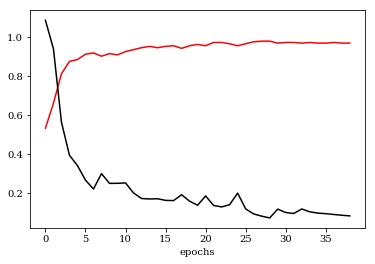

In [23]:
# 訓練の進み具合を可視化

val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(val_acc)), val_acc, label='val_acc', color='red')
plt.plot(range(len(val_loss)), val_loss, label='val_loss', color='black')

plt.xlabel('epochs')
plt.show()

In [24]:
# 予測精度の評価
loss_and_metrics = model.evaluate(X_validation, Y_validation)
print(loss_and_metrics) # 1番目：誤差関数の値、2番目：予測精度

298/298 [==============================] - 0s 462us/step
[0.084420920536781491, 0.96979865771812079]


In [25]:
# テスト用データを使用して予測する
X_predict = np.argmax(model.predict(X_test),axis=1)

In [26]:
# テスト用データフレームに結果を返す
i = 0
for index, row in df_account_test.iterrows():
    df_account_test.at[index, 'タイプコード'] = X_predict[i]
    df_account_test.at[index, '勘定タイプ'] = master_data.loc[X_predict[i],'勘定タイプ']
    i += 1

In [27]:
# 予測結果
df_account_test

,勘定コード,科目名,勘定タイプ,勘定クラス,タイプコード,Words
1490,1111009980,他預貯金-会社間取引2,資産,NaN,0.0,他 預貯金 - 会社 間 取引 2
1491,1132000062,売掛金(流)-一般(円貨),資産,NaN,0.0,売掛金 ( 流 )- 一般 ( 円貨 )
1492,2111109031,他短期借入金-グループ会社,負債,NaN,1.0,他 短期 借入金 - グループ 会社
1493,2151209820,他預り金-他2,負債,NaN,1.0,他 預り 金 - 他 2
1494,5111000005,製品売上高-関連会社レンタル,収益,NaN,3.0,製品 売上 高 - 関連 会社 レンタル
1495,5214000017,研究開発費-本社他2,費用,NaN,4.0,研究 開発 費 - 本社 他 2
1496,8131007621,自社利用ソフト-自社利用ソフトウェア3,費用,NaN,4.0,自社 利用 ソフト - 自社 利用 ソフトウェア 3
1497,9100000007,PL通過勘定7,資産,NaN,0.0,PL 通過 勘定 7


In [28]:
# 訓練データをテストデータを結合して新規科目マスターを作成する
df_account_result = pd.concat([df_account_train,df_account_test])

In [29]:
# 新規科目マスターをEXCELデータとして出力する
df_account_result.to_excel('data/訓練結果.xlsx', sheet_name='勘定科目一覧')